In [25]:
# imports

import os
import glob
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from datetime import datetime

from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages



# Import data

In [2]:

studies = [
    'data/MITHNEOS/gbo.ast.mithneos.spectra_2000-2021_V1_0/data/binzel2019',
    'data/MITHNEOS/gbo.ast.mithneos.spectra_2000-2021_V1_0/data/marsset2022',
]

# Initialize dictionaries to store data
spectral_data = {}
metadata = {}
neo_data = {}

for study in studies:
    data_dir = f'./{study}/'
    csv_files = glob.glob(os.path.join(data_dir, '*.csv'))
    
    for csv_file in csv_files:
        # Extract the NEO ID from the filename
        filename = os.path.basename(csv_file)
        neo_id = filename.split('_')[0]  # Assuming filenames are like '433_20161028.csv'
        
        # Read the spectral data CSV file
        data = pd.read_csv(csv_file, header=None, names=['Wavelength', 'Reflectance', 'Error'])
        
        # Read the corresponding XML file
        xml_file = csv_file.replace('.csv', '.xml')
        if os.path.exists(xml_file):
            tree = ET.parse(xml_file)
            root = tree.getroot()
            
            # Extract metadata from XML
            namespace = {'ns': 'http://pds.nasa.gov/pds4/pds/v1'}
            identification_area = root.find('ns:Identification_Area', namespace)
            observation_area = root.find('ns:Observation_Area', namespace)
            file_area = root.find('ns:File_Area_Observational', namespace)
            
            # Get logical_identifier (unique ID)
            logical_id = identification_area.find('ns:logical_identifier', namespace).text
            
            # Get observation times
            time_coords = observation_area.find('ns:Time_Coordinates', namespace)
            start_time = time_coords.find('ns:start_date_time', namespace).text
            stop_time = time_coords.find('ns:stop_date_time', namespace).text
            
            # Get target name
            target_identification = observation_area.find('ns:Target_Identification', namespace)
            target_name = target_identification.find('ns:name', namespace).text
            
            # Additional metadata can be extracted as needed
            
            # Store metadata
            meta = {
                'NEO_ID': neo_id,
                'Logical_ID': logical_id,
                'Start_Time': start_time,
                'Stop_Time': stop_time,
                'Target_Name': target_name,
                'Study': study
            }
        else:
            # Handle cases where XML file is missing
            meta = {
                'NEO_ID': neo_id,
                'Logical_ID': None,
                'Start_Time': None,
                'Stop_Time': None,
                'Target_Name': None,
                'Study': study
            }
        
        # Add the study and filename to the data
        data['NEO_ID'] = neo_id
        data['Study'] = study
        data['Filename'] = filename
        
        # Merge data and metadata
        data['Start_Time'] = meta['Start_Time']
        data['Stop_Time'] = meta['Stop_Time']
        data['Target_Name'] = meta['Target_Name']
        
        # Append to the spectral data dictionary
        if neo_id in spectral_data:
            spectral_data[neo_id] = pd.concat([spectral_data[neo_id], data])
        else:
            spectral_data[neo_id] = data
        
        # Store metadata
        if neo_id in metadata:
            metadata[neo_id].append(meta)
        else:
            metadata[neo_id] = [meta]



### Read observation parameters

In [3]:

marsset_meta_file = './data/MITHNEOS/gbo.ast.mithneos.spectra_2000-2021_V1_0/data/observationalparameters_marsset.csv'
marsset_meta = pd.read_csv(marsset_meta_file, header=None, names=[
    'ASTEROID_NUMBER',
    'ASTEROID_DESIGNATION',
    'ASTEROID_NAME',
    'FILENAME',
    'START_TIME_OBS',
    'STOP_TIME_OBS',
    'EXPOSURE_COUNT',
    'TOTAL_INTEGRATION_TIME',
    'RIGHT_ASCENSION',
    'DECLINATION',
    'AIRMASS',
    'DISTANCE_GEOCENTRIC',
    'DISTANCE_HELIOCENTRIC',
    'APPARENT_V_MAG',
    'SOLAR_PHASE_ANGLE',
    'SOLAR_ANALOG_STAR'
])

binzel_meta_file = './data/MITHNEOS/gbo.ast.mithneos.spectra_2000-2021_V1_0/data/observationalparameters_marsset.csv'
binzel_meta = pd.read_csv(binzel_meta_file, header=None, names=[
    'ASTEROID_NUMBER',
    'ASTEROID_DESIGNATION',
    'ASTEROID_NAME',
    'FILENAME',
    'START_TIME_OBS',
    'STOP_TIME_OBS',
    'EXPOSURE_COUNT',
    'TOTAL_INTEGRATION_TIME',
    'RIGHT_ASCENSION',
    'DECLINATION',
    'AIRMASS',
    'DISTANCE_GEOCENTRIC',
    'DISTANCE_HELIOCENTRIC',
    'APPARENT_V_MAG',
    'SOLAR_PHASE_ANGLE',
    'SOLAR_ANALOG_STAR'
])

marsset_meta['SOURCE'] = 'marsset'
binzel_meta['SOURCE'] = 'binzel'

combined_meta = pd.concat([marsset_meta, binzel_meta], ignore_index=True)

### Merge data

In [4]:
for neo_id in spectral_data:
    data = spectral_data[neo_id]
    filenames = data['Filename'].unique()
    meta_df = combined_meta[combined_meta['FILENAME'].isin(filenames)]
    if not meta_df.empty:
        data = data.merge(meta_df, left_on='Filename', right_on='FILENAME', how='left')
        
    spectral_data[neo_id] = data

### Formatting

In [5]:
# timestamps

for neo_id in spectral_data:
    data = spectral_data[neo_id]
    data['Start_Time'] = pd.to_datetime(data['Start_Time'])
    data['Stop_Time'] = pd.to_datetime(data['Stop_Time'])
    # data['START_TIME_OBS'] = pd.to_datetime(data['START_TIME_OBS'])
    # data['STOP_TIME_OBS'] = pd.to_datetime(data['STOP_TIME_OBS'])

    spectral_data[neo_id] = data


# missing values

for neo_id in spectral_data:
    data = spectral_data[neo_id]
    data.replace(['-1', '-'], [pd.NA, pd.NA], inplace=True)
    data = data.apply(pd.to_numeric, errors='ignore')
    
    spectral_data[neo_id] = data

/var/folders/b6/5kj2tkgn6vx8kxcyhfg6pf9c0000gn/T/ipykernel_90989/570522320.py:18: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data.apply(pd.to_numeric, errors='ignore')


### Make DataFrame

In [6]:
all_data = pd.concat(spectral_data.values(), ignore_index=True)

all_data.head()

,Wavelength,Reflectance,Error,NEO_ID,Study,Filename,Start_Time,Stop_Time,Target_Name
0,0.830,0.813,0.006,24445,data/MITHNEOS/gbo.ast.mithneos.spectra_2000-20...,24445_20031001.csv,1064986616000000000,1064990106000000000,(24445) 2000 PM8
1,0.835,0.804,0.005,24445,data/MITHNEOS/gbo.ast.mithneos.spectra_2000-20...,24445_20031001.csv,1064986616000000000,1064990106000000000,(24445) 2000 PM8
2,0.840,0.798,0.005,24445,data/MITHNEOS/gbo.ast.mithneos.spectra_2000-20...,24445_20031001.csv,1064986616000000000,1064990106000000000,(24445) 2000 PM8
3,0.845,0.791,0.005,24445,data/MITHNEOS/gbo.ast.mithneos.spectra_2000-20...,24445_20031001.csv,1064986616000000000,1064990106000000000,(24445) 2000 PM8
4,0.850,0.775,0.005,24445,data/MITHNEOS/gbo.ast.mithneos.spectra_2000-20...,24445_20031001.csv,1064986616000000000,1064990106000000000,(24445) 2000 PM8


# Preprocessing and feature extraction

### Normalization

In [7]:
# at 1

def re_normalize_spectrum(data):
    data = data[data['Reflectance'] != -1].copy()
    data['Wavelength'] = data['Wavelength'].astype(float)
    data['Reflectance'] = data['Reflectance'].astype(float)
    norm_wavelength = 1.0  # microns
    if norm_wavelength in data['Wavelength'].values:
        norm_factor = data.loc[data['Wavelength'] == norm_wavelength, 'Reflectance'].values[0]
    else:
        norm_factor = np.interp(norm_wavelength, data['Wavelength'], data['Reflectance'])
    if norm_factor == 0:
        print(f"Normalization factor is zero at wavelength {norm_wavelength} microns for NEO {data['NEO_ID'].iloc[0]}.")
        return data
    data['Normalized_Reflectance'] = data['Reflectance'] / norm_factor
    return data


# alt approach of normalization over a range
def re_normalize_spectrum_range(data, norm_wavelength, delta=0.02):
    data = data[data['Reflectance'] != -1].copy()
    data['Wavelength'] = data['Wavelength'].astype(float)
    data['Reflectance'] = data['Reflectance'].astype(float)
    lower_bound = norm_wavelength - delta
    upper_bound = norm_wavelength + delta
    mask = (data['Wavelength'] >= lower_bound) & (data['Wavelength'] <= upper_bound)
    reflectance_values = data.loc[mask, 'Reflectance']
    if reflectance_values.empty:
        print(f"No data available in the normalization range for NEO {data['NEO_ID'].iloc[0]}")
        return data
    norm_factor = reflectance_values.mean()
    data['Normalized_Reflectance'] = data['Reflectance'] / norm_factor
    return data


for neo_id in spectral_data:
    data = spectral_data[neo_id]
    normalized_data = re_normalize_spectrum(data)
    # normalized_data = re_normalize_spectrum_range(data, norm_wavelength=1.0, delta=0.02)
    spectral_data[neo_id] = normalized_data



In [8]:
all_data = all_data.groupby(['Filename']).apply(re_normalize_spectrum).reset_index(drop=True)
print(all_data.columns)

Index(['Wavelength', 'Reflectance', 'Error', 'NEO_ID', 'Study', 'Filename',
       'Start_Time', 'Stop_Time', 'Target_Name', 'Normalized_Reflectance'],
      dtype='object')


/var/folders/b6/5kj2tkgn6vx8kxcyhfg6pf9c0000gn/T/ipykernel_90989/1526837363.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_data = all_data.groupby(['Filename']).apply(re_normalize_spectrum).reset_index(drop=True)


### Caliculate spectral slope

In [9]:
def calculate_spectral_slope(data, start_wavelength, end_wavelength):
    mask = (data['Wavelength'] >= start_wavelength) & (data['Wavelength'] <= end_wavelength)
    wavelength_range = data.loc[mask, 'Wavelength']
    reflectance_range = data.loc[mask, 'Normalized_Reflectance']
    
    if len(wavelength_range) < 2:
        return np.nan
    
    slope_coeffs = np.polyfit(wavelength_range, reflectance_range, 1)
    spectral_slope = slope_coeffs[0]
    return spectral_slope


# adjust for band-depth

def calculate_band_depth(data, band_range):
    mask = (data['Wavelength'] >= band_range[0]) & (data['Wavelength'] <= band_range[1])
    band_data = data.loc[mask]
    if band_data.empty:
        return np.nan
    wavelengths = band_data['Wavelength'].values
    reflectance = band_data['Normalized_Reflectance'].values
    left_edge = band_range[0]
    right_edge = band_range[1]
    left_reflectance = np.interp(left_edge, data['Wavelength'], data['Normalized_Reflectance'])
    right_reflectance = np.interp(right_edge, data['Wavelength'], data['Normalized_Reflectance'])
    continuum = interp1d([left_edge, right_edge], [left_reflectance, right_reflectance], kind='linear')
    continuum_reflectance = continuum(wavelengths)
    band_depth = 1 - (reflectance / continuum_reflectance)
    max_band_depth = np.max(band_depth)
    return max_band_depth

def calculate_band_center(data, band_range):
    mask = (data['Wavelength'] >= band_range[0]) & (data['Wavelength'] <= band_range[1])
    band_data = data.loc[mask]
    if band_data.empty:
        return np.nan
    wavelengths = band_data['Wavelength'].values
    reflectance = band_data['Normalized_Reflectance'].values
    left_edge = band_range[0]
    right_edge = band_range[1]
    left_reflectance = np.interp(left_edge, data['Wavelength'], data['Normalized_Reflectance'])
    right_reflectance = np.interp(right_edge, data['Wavelength'], data['Normalized_Reflectance'])
    continuum = interp1d([left_edge, right_edge], [left_reflectance, right_reflectance], kind='linear')
    continuum_reflectance = continuum(wavelengths)
    band_depth = 1 - (reflectance / continuum_reflectance)
    band_center_index = np.argmax(band_depth)
    band_center_wavelength = wavelengths[band_center_index]
    return band_center_wavelength

In [10]:
# get band info for band range (0.9-1.1 silicate materials)

def extract_features(group):
    wavelengths = group['Wavelength'].values
    reflectance = group['Normalized_Reflectance'].values
    
    data = group.copy()
    
    # Recalculate Spectral Slope
    spectral_slope = calculate_spectral_slope(data, start_wavelength=0.8, end_wavelength=1.5)
    
    # Calculate Band Depth at 1-micron Band (associated with silicates or olivene)
    band_depth_1um = calculate_band_depth(data, band_range=(0.9, 1.1))
    band_center_1um = calculate_band_center(data, band_range=(0.9, 1.1))

    #  Calculate Band Depth at 2-micron Band: ~1.8 to 2.2 microns (associated with pyroxene minerals or pyroxene)
    band_depth_2um = calculate_band_depth(data, band_range=(1.8, 2.2))
    band_center_2um = calculate_band_center(data, band_range=(1.8, 2.2))
    
    # Calculate Mean Reflectance (optional, may not be necessary after normalization)
    mean_reflectance = reflectance.mean()
    
    # Aggregate features
    features = {
        'NEO_ID': group['NEO_ID'].iloc[0],
        'Spectral_Slope': spectral_slope,
        'Band_Depth_1um': band_depth_1um,
        'Band_Center_1um': band_center_1um,
        'Band_Depth_2um': band_depth_2um,
        'Band_Center_2um': band_center_2um,
        'Mean_Reflectance': mean_reflectance
    }
    return pd.Series(features)



### Apply to data

Spectral Slope:

A positive slope indicates increasing reflectance with wavelength (reddening), which may suggest certain types of asteroid compositions.
A negative slope indicates decreasing reflectance with wavelength (bluing).

Band Depth:

Deeper bands (higher band depth values) suggest stronger absorption features, indicating the presence of specific minerals.
For example, a significant 1-micron band depth may indicate silicate-rich asteroids.

In [11]:
# Apply the updated feature extraction function
features_df = all_data.groupby(['Filename']).apply(extract_features).reset_index()

neo_features = features_df.groupby('Filename').agg({
    'Spectral_Slope': 'mean',
    'Band_Depth_1um': 'mean',
    'Band_Center_1um': 'mean',
    'Band_Depth_2um': 'mean',
    'Band_Center_2um': 'mean',
    'Mean_Reflectance': 'mean'
}).reset_index()

/var/folders/b6/5kj2tkgn6vx8kxcyhfg6pf9c0000gn/T/ipykernel_90989/2090991722.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_df = all_data.groupby(['Filename']).apply(extract_features).reset_index()


# Anomaly detection preprocess

In [ ]:
# we're chop some data around to make it work for iso forest

### first i noticed some duplicate entries for wavelength
# 102 rows have this issue
# exmaple marsset2022/2062_20150206.csv lines 71 and 104
# not a big deal but becomes an issue when grouping and pivoting
# going to drop duplicate rows based off of error value

wavelength_sorted = all_data.sort_values(by=['Filename', 'Wavelength', 'Error'])

# drop rows in the DataFrame that wavelenghts are not x.xx5 and x.xx0 because of sparse data
wavelength_filtered = wavelength_sorted[wavelength_sorted['Wavelength'].apply(lambda x: str(x)[-1] in {'5', '0'})]
wavelength_deduplicated = wavelength_filtered.drop_duplicates(subset=['Filename', 'Wavelength'], keep='first')
wavelength_pivoted = wavelength_deduplicated.pivot(index='Filename', columns='Wavelength', values='Reflectance')

In [13]:
total_rows = len(wavelength_pivoted)
null_counts = wavelength_pivoted.isnull().sum()
null_percentage = (null_counts / total_rows) * 100
null_percentage_df = null_percentage.reset_index()
null_percentage_df.columns = ['Column', 'Null_Percentage']
pd.set_option('display.max_rows', None)
print(null_percentage_df)
pd.reset_option('display.max_rows')

     Column  Null_Percentage
0     0.650        98.959688
1     0.655        98.829649
2     0.665        99.219766
3     0.675        96.228869
4     0.685        93.758127
5     0.695        90.637191
6     0.705        85.435631
7     0.715        84.785436
8     0.725        84.265280
9     0.735        83.355007
10    0.745        82.574772
11    0.750        83.745124
12    0.755        81.534460
13    0.765        74.122237
14    0.775        66.319896
15    0.785        42.652796
16    0.795        36.801040
17    0.805        30.819246
18    0.815        29.388817
19    0.825         9.362809
20    0.835         5.461638
21    0.845         3.771131
22    0.850         2.990897
23    0.855         2.730819
24    0.865         2.210663
25    0.875         2.730819
26    0.885         2.080624
27    0.895         1.170351
28    0.905         1.300390
29    0.915         1.040312
30    0.925         1.170351
31    0.935         2.860858
32    0.945         1.950585
33    0.950   

In [14]:
# Drop columns (wavelengths) oustide of 0.850 - 2.350 because of sparse data
wavelength_pivoted_trunc = wavelength_pivoted.loc[:, (wavelength_pivoted.columns >= 0.850) & (wavelength_pivoted.columns <= 2.350)]

#inspect data
# wavelength_pivoted_trunc.to_csv('data/outputs/wavelength_pivoted_trunc.csv', index=False)

# Filter out NEOs with really sparse readings (where over 25% of wavelengths are null)
not_enough_data_mask = (wavelength_pivoted_trunc.isnull().sum(axis=1) / len(wavelength_pivoted_trunc.columns)) < 0.25
# using mask after rejoin of other features via index on filename

# Perform spline interpolation to fill missing values
wavelength_pivoted_trunc_spline = wavelength_pivoted_trunc.interpolate(method='spline', order=3, axis=1, limit_direction='both')

wavelength_pivoted_trunc_spline['not_enough_data_mask'] = not_enough_data_mask.astype(bool)

# join up the features made for iso forest
neo_features_wavy = neo_features.merge(wavelength_pivoted_trunc_spline, left_on='Filename', right_index=True, how='left')

# Delete offending (6) rows with not_enough_data_mask filter
neo_features_wavy_filtered = neo_features_wavy[neo_features_wavy['not_enough_data_mask'] == True]
print(len(neo_features_wavy))
print(len(neo_features_wavy_filtered))


769
763


## Iso Forest

In [15]:
iso_forest_df = neo_features_wavy_filtered.copy()

print(iso_forest_df.columns)

feature_columns = [
    'Spectral_Slope',
    'Band_Depth_1um',
    'Band_Center_1um',
    'Band_Depth_2um',
    'Band_Center_2um',
    'Mean_Reflectance'
]
X = iso_forest_df[feature_columns].dropna()


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.08,
    max_samples=0.7,
    max_features=0.5,
    random_state=42
)

# Fit the model
iso_forest.fit(X_scaled)

# Predict anomalies
anomaly_scores = iso_forest.decision_function(X_scaled)
anomaly_labels = iso_forest.predict(X_scaled)
iso_forest_df['IsoForest_Score'] = anomaly_scores
iso_forest_df['IsoForest_Label'] = anomaly_labels

# NEOs classified as anomalies
anomalous_neos = iso_forest_df[iso_forest_df['IsoForest_Label'] == -1]
anomalous_filenames = set(anomalous_neos['Filename'])


print("Anomalous NEOs:")
anomalous_neos_sorted = iso_forest_df.sort_values(by='IsoForest_Score', ascending=True)
print(anomalous_neos_sorted[['Filename', 'IsoForest_Label']])


Index([            'Filename',       'Spectral_Slope',       'Band_Depth_1um',
            'Band_Center_1um',       'Band_Depth_2um',      'Band_Center_2um',
           'Mean_Reflectance',                   0.85,                  0.855,
                        0.865,
       ...
                        2.275,                  2.285,                  2.295,
                        2.305,                  2.315,                  2.325,
                        2.335,                  2.345,                   2.35,
       'not_enough_data_mask'],
      dtype='object', length=177)
Anomalous NEOs:
                  Filename  IsoForest_Label
44     137924_20150218.csv               -1
45     137924_20200121.csv               -1
192  2000bo28_20200227.csv               -1
573    454100_20181107.csv               -1
122    162687_20181111.csv               -1
..                     ...              ...
700      6585_20061025.csv                1
146     16834_20090920.csv                1
181   

## Principal Component Analysis

In [16]:
#### some data munging here to turn wavelength coumn names into strings and delete other columns
neo_pca = neo_features_wavy_filtered.copy()
neo_pca = neo_pca.set_index('Filename')
string_columns = [col for col in neo_pca.columns if isinstance(col, str)]
neo_pca = neo_pca.drop(columns=string_columns)
stringify_columns = [str(col) for col in neo_pca.columns]
######
###### make a copy for dbscan
neo_dbs = neo_pca.copy()
####

In [ ]:
X = neo_pca.dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
pca_result = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust clusters as needed
labels = kmeans.fit_predict(pca_result)
neo_pca['Cluster'] = labels

# print(neo_pca['Cluster'].unique)
neo_pca = neo_pca.reset_index()
neo_pca_kmeans = neo_pca[['Filename', 'Cluster']]
print(neo_pca_kmeans['Cluster'].unique())
print(neo_pca_kmeans['Cluster'].value_counts())

# TODO inspect manually

# DB Scan creates same 5 results

[3 4 2 0 1]
Cluster
3    398
4    288
0     46
1     29
2      2
Name: count, dtype: int64


## FFT

In [ ]:
### FFT

# Vizualize

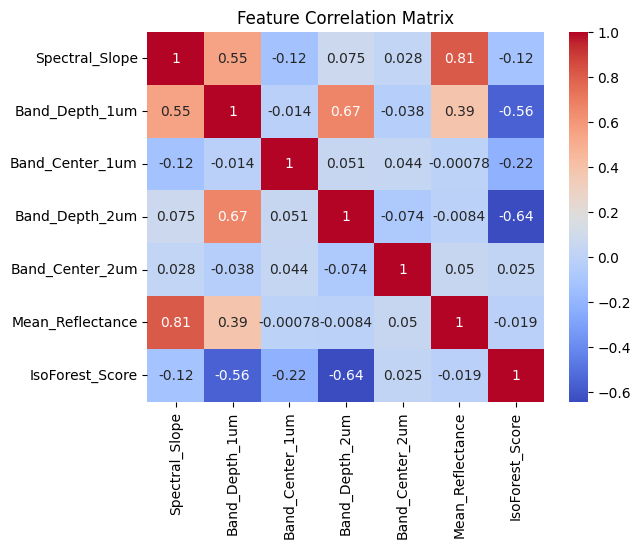

In [18]:
# a little chart action
iso_forest_df_mtx = iso_forest_df[[
    'Spectral_Slope',
    'Band_Depth_1um',
    'Band_Center_1um',
    'Band_Depth_2um',
    'Band_Center_2um',
    'Mean_Reflectance',
    'IsoForest_Score'
]]

# Compute correlation matrix
corr_matrix = iso_forest_df_mtx.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [27]:
# For PDFs

pdf_df = all_data.copy()

nrows = 5
ncols = 4
plots_per_page = nrows * ncols

cluster_colors = {
    0: 'blue',      # Cluster 0
    1: 'green',     # Cluster 1
    2: 'purple',    # Cluster 2
    3: 'orange',    # Cluster 3
    4: 'cyan'       # Cluster 4
}

if 'Normalized_Reflectance' not in all_data.columns:
    pdf_df = pdf_df.groupby(['Filename']).apply(re_normalize_spectrum).reset_index(drop=True)
observations = pdf_df[['NEO_ID', 'Filename', 'Target_Name']].drop_duplicates().reset_index(drop=True)

# merge clusteres neo_pca_kmeans  ###### ???
observations_clusters = pd.merge(observations, neo_pca_kmeans, on='Filename', how='left')  ###### ???

total_plots = len(observations_clusters)
num_pages = int(np.ceil(total_plots / plots_per_page))
pdf_filename = 'data/outputs/neo_analysis.pdf'
with PdfPages(pdf_filename) as pdf:
    for page in range(num_pages):
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*2.5))
        axes = axes.flatten()
        start_idx = page * plots_per_page
        end_idx = min(start_idx + plots_per_page, total_plots)
        page_observations = observations_clusters.iloc[start_idx:end_idx]
        for idx, (index, row) in enumerate(page_observations.iterrows()):
            ax = axes[idx]
            neo_id = row['NEO_ID']
            filename = row['Filename']
            target_name = row['Target_Name'] 

            cluster = row['Cluster'] ###### ???
            color = cluster_colors.get(cluster, 'gray') ###### ???

            data = all_data[(all_data['NEO_ID'] == neo_id) & (all_data['Filename'] == filename)].copy()
            ax.plot(data['Wavelength'], data['Normalized_Reflectance'], color=color, linewidth=1)

            # add target name inside of plot (uncomment for regular title instead)
            ax.set_title(f'{neo_id} ({filename})', fontsize=8)
            # ax.set_title(f'{neo_id} ({filename})\n{target_name}', fontsize=8)
            ax.text(0.5, 0.9, f'{target_name}', transform=ax.transAxes, fontsize=7, ha='center')
            ax.set_xlabel('Wavelength (μm)', fontsize=7)
            ax.set_ylabel('Reflectance', fontsize=7)
            ax.tick_params(axis='both', which='major', labelsize=6)
            ax.axvspan(0.9, 1.1, color='red', alpha=0.2)
            ax.axvspan(1.8, 2.2, color='blue', alpha=0.2)
            ax.grid(True)

            # add boundry for iso forest
            if filename in anomalous_filenames:
                for spine in ax.spines.values():
                    spine.set_edgecolor('red')
                    spine.set_linewidth(2)

            plt.tight_layout()
        
        for idx in range(len(page_observations), len(axes)):
            fig.delaxes(axes[idx])
        
        pdf.savefig(fig)
        plt.close(fig)

        handles = [plt.Line2D([0], [0], color=color, lw=2, label=f'Cluster {i}')
           for i, color in cluster_colors.items()]
        fig.legend(handles=handles, loc='upper right', fontsize=8)

print(f'All thumbnail plots saved to {pdf_filename}')


All thumbnail plots saved to data/outputs/neo_analysis.pdf


### TODOs

Spectral Unmixing:
Use algorithms like Multiple Endmember Spectral Mixture Analysis (MESMA).

Spectral Libraries:
Match asteroid spectra to library spectra to infer composition.

Combine spectral analysis with other asteroid characteristics (e.g., density, orbit, albedo).
